# Data Cleanup: Removing Corporates' Customer Service Twitter accounts
The goal of this notebook is to show how I got rid of all Twitter usernames belonging to corporate/business accounts that were specifically created to deal with **customer service inquiries** or similar. As a rule of thumb, they generate an insane amount of traffic in terms of tweets since they directly reply to questions or concerns raised by other users. This is not only common for customer support accounts but also for TV/radio programs, internet providers, restaurants etc. All these accounts represent some kind of noise in our data, reason why we would like to get rid of them.

The end result will be a set of node IDs that will be removed from the MMR network, along with all their edges and the 0-degree nodes generated from this removal. The overall path I'll follow is to first collect all *potential* unwanted usernames in a separate set, by considering some username patterns criteria, then apply further filtering to figure out which usernames are more likely to be *actual* customer service accounts by checking some specific requirements with the help of Twitter API.

In [6]:
import operator
import nltk
import string
import pandas as pd
from pandas import DataFrame
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib as mpl
import os
sns.set_style("darkgrid")
pd.set_option("display.precision", 3)
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['savefig.dpi'] = 100
pictures_path = os.path.join("../Pictures", "5.1.DataCleanup")

def show_data_as_dataframe(data, column_labels):
    df = DataFrame(data, columns=column_labels)
    display(df)
    return df

def cast_to_original_types(df, columns, df_types_dict):
    for column in columns:
        df[column] = df[column].astype(df_types_dict[column])

In [2]:
# Let's read back the node degrees that were dumped from the Notebook 5.NetworkMetrics.ipynb
node_degrees_df = pd.read_csv("../data/temp/node_degrees.csv", header=None, names=["encoding","degree"])

In [8]:
# Cast column types to improve memory performance
cast_to_original_types(node_degrees_df, ["encoding", "degree"], {"encoding": np.uint32, "degree": np.uint16})

In [36]:
potential_unwanted_data = set()

def update_set(set_to_update, new_values):
    if type(new_values) == str:
        new_values = [int(el) for el in new_values.split('\n') if el != '']
    set_to_update.update(new_values)

## 1. Extract usernames from List of Twitter Corporate Accounts
The Internet provided me with a convenient yet not properly structured and incomplete [list of Twitter Corporate Accounts](https://gist.github.com/mbejda/45db05ea50e79bc42016#file-fortune-1000-company-twitter-accounts-csv), that could help me instantly figure out which Twitter usernames actually belong to a company and not a private user. I cleaned and polished the original CSV file, came up with a list of 428 Twitter corporate usernames and created a new bash script `1.find_companies_usernames_from_list.sh` to actually check which corporate accounts are included in our data:
~~~bash
while IFS= read -r h
do
    egrep "^$h," -i -m 1 "$2" | tee -a ../data/data_cleanup/found_companies.csv
done < "$1"
~~~
Therefore I ran the script with:
~~~bash
./1.find_companies_usernames_from_list.sh /path/to/twitter_companies.txt /path/to/usernames.csv
~~~
and got the `found_companies.csv` output file with **366 unique entries**. All these may be added to the `potential_dirty_data` set:

In [38]:
%%bash --out shell_output
# Get only the IDs to work on in Python
awk -F "," '{print $2}' ../data/data_cleanup/found_companies.csv

In [39]:
update_set(potential_unwanted_data, shell_output)

## 2. Extract usernames that match common Customer Service patterns
Since the provided input list is not meant to be a full extensive list of *all* Twitter corporate accounts, there's still a lot of unwanted data that could be cleaned up. By skimming through the nodes with highest degree ($k \gt 500$), I could easily infer some of the most common username patterns for Corporate/Business Customer Service accounts, hereby listed with wildcard patterns:
~~~
*support, *care, *cares, *help, *helps, *helpers, *helpdesk, *assist, *serviceteam, *helpteam, ask*, *custsvc, *movistar*,
xboxsupport*, vodafone*, *airways, *playstation*
~~~

A few examples are `stccare`, `xboxsupport`, `amazonhelp`. I included all these patterns in `customer_service_patterns.txt` and let it parse by the new script `2.find_customer_service_usernames.sh`:

~~~bash
egrep -f /path/to/customer_service_patterns.txt /path/to/usernames.csv | tee -a /path/to/found_companies.csv
sort -u /path/to/found_companies.csv > /path/to/found_companies_nodup.csv # Remove duplicates
mv /path/to/found_companies_nodup.csv /path/to/found_companies.csv
~~~

There are **35323** accounts that fall within this category, so I append them to the `found_companies.csv` file and remove the duplicates. At this point, I can also add them to the set of the potential dirty data:

In [40]:
%%bash --out shell_output
# Get only the IDs to work on in Python
awk -F "," '{print $2}' ../data/data_cleanup/found_companies.csv

In [41]:
update_set(potential_unwanted_data, shell_output)

In [42]:
len(potential_unwanted_data)

35667

So far we got a total of **35667** potential unwanted usernames.

## 3. Manual identification of remaining Customer Service accounts 
Lastly, here's a set of **34** accounts that would not be captured by the patterns identified above, but still represent Corporate/Business accounts that deal with customer support. The most common are related to internet/TV providers, restaurants, gaming, supermarkets, music & movies, TV shows.

~~~
orangeuk, xbox, pizzahut, itau, cocanomc, mtv, ee, o2, postnl, yogurstand,
eatbulaga, sainsburys, telstra, mobily, southwestair, united, easyjet, aircanada, optus, optussport, skyresponde,
captainamerica, delta, kenyapower, tesco, tescomobile, telkomsel, virginmedia, erpestar, tacobell,
alphabetsuccess, personalar, onrpe, klm
~~~

All these may then be extracted by another script, `3.find_hardcoded_companies.sh`, which reads all patterns specified in the file `hardcoded_companies.txt`:
~~~bash
egrep -f hardcoded_companies.txt /path/to/usernames.csv | tee -a /path/to/found_companies.csv
sort -u /path/to/found_companies.csv > /path/to/found_companies_nodup.csv # Remove duplicates
mv /path/to/found_companies_nodup.csv /path/to/found_companies.csv
~~~

In [43]:
%%bash --out shell_output
# Get only the IDs to work on in Python
awk -F "," '{print $2}' ../data/data_cleanup/found_companies.csv

In [44]:
update_set(potential_unwanted_data, shell_output)

In [45]:
print("Total number of potential unique companies to be removed: {0}".format(len(potential_unwanted_data)))

Total number of potential unique companies to be removed: 35701


In [475]:
# Remove set from memory, will use the file from now on
del potential_unwanted_data

## 4. Run verification checks and build final list
Now that I have a list of **35701 potential corporate accounts** I can state which ones actually represent unwanted noise in our data by performing one last check that combines multiple criteria I've thought about. I'll evaluate how much a given username belongs to a company account by considering (in order of importance):
- **Verified** status of the Twitter account;
- The number of "Customer Service" keywords the Twitter account description features;
- The degree $k$ of the node in the graph;
- The number of issued tweets.

These are simple criteria that aren't necessarily sufficient to guarantee a 100\% match for a corporate account. The main drawback is excluding from the analysis a (relatively low) number of accounts that are reported as false positives; on the other hand, I would still not be able to detect *all* corporate accounts, because of the degree threshold limitation. Furthermore, I assume the description is written in English language, whereas there might be cases of foreign accounts that only use local language. Lowering the threshold too much would mean capturing more corporate accounts and at the same time more false positives. The combination of the three criteria shown above should represent a reasonable trade-off that should capture most of the real corporate accounts and not too many false-positives.

I identified a set of keywords that most Customer Service accounts are including in their account description and included them in `twitter_description_keywords.txt`. A few examples are:
~~~
customer,customers,support,service,help,ask,team,care,information,helpteam,questions,
concerns,inquiries,assistance,assist,answers,queries,official
~~~

Twitter APIs may come handy to easily check the first two requirements, and for this reason I wrote a new Python script that queries the APIs to fetch the needed result named `4.find_potential_corporate_accounts.py`. Since Twitter APIs, when running batch-queries to lookup for usernames, don't include data for the usernames not found, I only save data for the currently existing usernames and therefore won't include the non-existing usernames in the set of potential companies accounts.

The script managed to get metadata for a total of **24249** usernames (whereas **11099** were not found), that I may now conveniently process as a Pandas Dataframe:

In [335]:
df_dtypes = {"username": str,
             "encoding": np.uint32,
             "is_verified": np.bool,
             "tweets": np.uint16,
             "keywords": np.uint8,
             "degree": np.uint16}

In [143]:
potential_unwanted_data_df = pd.read_csv("../data/data_cleanup/found_companies_metadata.csv", header=None, names=["username","encoding","is_verified","tweets","keywords"], dtype=df_dtypes)

Let's now include the `degree` column to the DataFrame by merging two DataFrames:

In [144]:
potential_unwanted_data_df = potential_unwanted_data_df.merge(node_degrees_df, on="encoding")
potential_unwanted_data_df.head(10)

,username,encoding,is_verified,tweets,keywords,degree
0,a1cares,47290350,False,228,0,1
1,a1floodhelp,45670304,False,389,1,1
2,a2assist,68911384,False,13989,1,2
3,aaacares,22444328,False,13450,1,19
4,aab0000care,44480371,False,14,0,1
5,aadoesntcare,68735735,False,7,0,1
6,aahomecare,22132351,False,4235,0,15
7,aaihelps,89242081,False,1987,1,1
8,aangelocustcare,18885859,False,198,5,3
9,aapsupport,6569103,False,4,2,5


In order to highlight the companies that are more likely to be true positive matches, I have to **sort** the DataFrame in a reasonable way. This would make it possible to see on top the usernames that are more likely to be true positives.

In [227]:
potential_unwanted_data_df.sort_values(["is_verified", "keywords", "degree", "tweets"], ascending=[False, False, False, False], inplace=True)
potential_unwanted_data_df.head(20)

,username,encoding,is_verified,tweets,keywords,degree
11434,avivauksupport,1597439,True,58523,12,364
12568,centurylinkhelp,4969228,True,5995,10,471
12918,comcastcares,33244383,True,30372,9,6673
21174,santanderukhelp,1957562,True,2263,9,1378
13866,dropboxsupport,59417015,True,36263,9,426
9072,askpermanenttsb,12752131,True,21999,9,178
10665,askvirginmoney,51468569,True,17348,9,113
4131,askcybersmile,45935001,True,3749,9,8
12156,btcare,46286,True,19211,8,19399
12624,chasesupport,694524,True,21806,8,1768


### 4.1 Basic descriptive statistics for companies data
In order to find the best combination of the criteria described in the previous section, it might be convenient to first show some descriptive statistics of the companies data. Boxplots may be convenient at this point to show some basic info for numerical data.

In [228]:
for value in [True, False]:
    num = len(potential_unwanted_data_df[potential_unwanted_data_df["is_verified"] == value].index)
    percent = round((num*1.0/len(potential_unwanted_data_df.index))*100,2)
    total = len(potential_unwanted_data_df.index)
    print("{0} usernames with 'is_verified' == {1} --- {2}% of {3}".format(num, value, percent, total))

876 usernames with 'is_verified' == True --- 3.61% of 24249
23373 usernames with 'is_verified' == False --- 96.39% of 24249


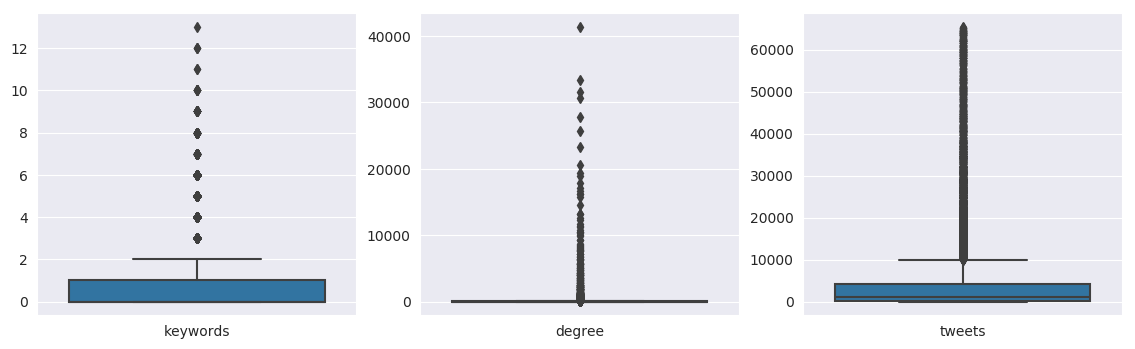

In [244]:
plt.figure(figsize=(14,4))
for i,column in enumerate(["keywords","degree","tweets"]):
    plt.subplot(1,3,i+1)
    sns.boxplot(data=potential_unwanted_data_df[[column]])
plt.savefig(os.path.join(pictures_path,"boxplot_companies.png"))

It is clear from the boxplots above that the outliers in the data play a significant role, which makes it almost impossible to read the plots. A textual summary of the same date may be obtained by a built-in function in Pandas:

In [208]:
potential_unwanted_data_df.drop(columns=["encoding"]).describe()

,tweets,keywords,degree
count,24249.000,24249.000,24249.000
mean,4627.845,0.566,57.667
std,9424.730,1.260,756.497
min,0.000,0.000,1.000
25%,179.000,0.000,1.000
50%,991.000,0.000,3.000
75%,4110.000,1.000,9.000
max,65404.000,13.000,41359.000


By looking at the **median** value (corresponding to the 50th-percentile) and the 25th, 75th percentiles compared to the $min$ and $max$ values for each column, it's clear indeed how most observations have values that are closer to the $min$ value than to the $max$ value. Indeed, this is a clear demonstration that, by considering the (1) number of tweets, (2) number of description keywords and (3) degree criteria, only a small subset of observations actually correspond to true positives.

It is crucial, however, pointing out that in order to be as much precise as possible, it's not sufficient to simply filter out all the outliers. There might be still (lots of) companies that are not marked as outliers, and there might be normal accounts that are instead marked as outliers. Therefore, a **reasonable filtering** that combines all the three criteria mentioned above has to be enforced to capture as many true positives as possible and the least false positives. I may iterate multiple times before reaching the best condition.

### 4.2 Exclude accounts with low degree
Since the degree is the attribute that affects the most the network structure, we may exclude all those entries whose degree fall below the 75th percentile:

In [315]:
potential_unwanted_data_df = potential_unwanted_data_df[potential_unwanted_data_df["degree"] >= 10]

In [317]:
potential_unwanted_data_df.drop(columns=["encoding"]).describe()

,tweets,keywords,degree
count,5687.000,5687.000,5687.000
mean,12367.481,0.870,237.288
std,14538.756,1.724,1548.663
min,0.000,0.000,10.000
25%,2266.500,0.000,14.000
50%,6733.000,0.000,24.000
75%,16784.000,1.000,54.000
max,65404.000,13.000,41359.000


In [320]:
potential_unwanted_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5687 entries, 11434 to 24103
Data columns (total 6 columns):
username       5687 non-null object
encoding       5687 non-null uint32
is_verified    5687 non-null bool
tweets         5687 non-null uint16
keywords       5687 non-null uint8
degree         5687 non-null uint16
dtypes: bool(1), object(1), uint16(2), uint32(1), uint8(1)
memory usage: 144.4+ KB


### 4.3 Dealing with more obvious Customer Support accounts
It's time now to create a new DataFrame to store the *really unwanted data*. I may start by including all those usernames that are **Verified** *and satisfy at least 2 of the conditions below*:
- Degree must be relatively high: $k \geq 500 \simeq 50*\langle k \rangle$;
- Account must feature at least *1 description keywords*;
- Number of tweets has to be high: $tweets \geq 500$.

In [322]:
really_unwanted_data_df = potential_unwanted_data_df[(potential_unwanted_data_df["is_verified"]) &
                           (((potential_unwanted_data_df["tweets"] >= 500) &
                            (potential_unwanted_data_df["degree"] >= 500)) |
                            ((potential_unwanted_data_df["tweets"] >= 500) &
                             (potential_unwanted_data_df["keywords"] >= 1)) |
                            ((potential_unwanted_data_df["degree"] > 500) &
                             (potential_unwanted_data_df["keywords"] >= 1)))]

In [325]:
potential_unwanted_data_df = potential_unwanted_data_df[~potential_unwanted_data_df.isin(really_unwanted_data_df)].dropna()

In [337]:
# Restore data types
cast_to_original_types(potential_unwanted_data_df, list(potential_unwanted_data_df.columns), df_dtypes)

### 4.4 Dealing with less obvious Customer Support accounts
Let's remove the `is_verified` attribute from the columns to be sorted, since this might help to get a new view of the remaining entries in the potential companies data:

In [350]:
potential_unwanted_data_df.sort_values(["degree", "tweets", "keywords"], ascending=[False, False, False], inplace=True)
potential_unwanted_data_df.head(5)

,username,encoding,is_verified,tweets,keywords,degree
14259,erpestar,59012597,False,33735,0,17097
23908,xboxsupport1,167064,False,731,5,10472
23950,xlcare,17078,False,0,5,9833
23910,xboxsupport2,92309,False,926,5,9332
23911,xboxsupport3,46794,False,60205,5,9240


There are still many customer support accounts that need new filtering conditions in order to be captured. At this point, it might make more sense to use the information provided by the upper **percentiles** and filter out the outliers:

In [389]:
potential_unwanted_data_df.drop(columns=["encoding","is_verified"]).quantile([0.75,0.9,0.95,0.99,1])

,tweets,keywords,degree
0.75,14994.00,0.0,43.00
0.90,30633.60,2.0,104.00
0.95,42726.00,4.0,185.40
0.99,59991.18,7.0,595.98
1.00,65404.00,13.0,17097.00


Since I noticed that lots of potential false positives are usernames that match the pattern *ask\**, I'll deal separately with them and include a custom condition. As of now, according to the above percentiles, I consider reasonable excluding the outliers that fall (approximately) above the **95th percentile**:

In [397]:
really_unwanted_data_df = really_unwanted_data_df.append(potential_unwanted_data_df[((potential_unwanted_data_df["tweets"] > 42000) |
                           (potential_unwanted_data_df["keywords"] >= 4) |
                           (potential_unwanted_data_df["degree"] > 200)) &
                           (~potential_unwanted_data_df["username"].str.startswith("ask"))])

potential_unwanted_data_df = potential_unwanted_data_df[~potential_unwanted_data_df.isin(really_unwanted_data_df)].dropna()

# Restore data types
cast_to_original_types(potential_unwanted_data_df, list(potential_unwanted_data_df.columns), df_dtypes)

### 4.5 Manually dealing with remaining Customer Support accounts

In [408]:
potential_unwanted_data_df.sort_values(by="keywords", ascending=False, inplace=True)
potential_unwanted_data_df.head(10)

,username,encoding,is_verified,tweets,keywords,degree
4507,askecggh,83046897,False,1219,10,12
9615,asksageuki,51197632,False,6007,10,44
9967,asksurfline,51420533,False,3300,9,41
9683,askseagate,6739496,False,37849,9,335
9942,asksubarucanada,23477542,False,1337,9,10
1145,ask123ie,46240420,False,2251,8,16
4469,askdysonus,8718814,False,13364,8,42
4465,askdyson,10540922,False,29253,8,148
4466,askdysonau,30431399,False,4942,8,21
7712,askloot,87090976,False,16687,8,16


In [413]:
print("Number of remaining potential corporate accounts: {0}".format(len(potential_unwanted_data_df.index)))
print("Number of remaining potential corporate accounts whose usernames start with 'ask': {0}".format(len(potential_unwanted_data_df[potential_unwanted_data_df["username"].str.startswith("ask")].index)))

Number of remaining potential corporate accounts: 4627
Number of remaining potential corporate accounts whose usernames start with 'ask: 2093


Most of the remaining potential customer service accounts (~45%) apparently match the *ask\** pattern we have previously excluded. I may be more strict with the filtering in order to better capture the true positives and enforce that there must be at least 3 description keywords:

In [422]:
really_unwanted_data_df = really_unwanted_data_df.append(potential_unwanted_data_df[(potential_unwanted_data_df["username"].str.startswith("ask")) &
                                                                                    (potential_unwanted_data_df["keywords"] > 2)])

potential_unwanted_data_df = potential_unwanted_data_df[~potential_unwanted_data_df.isin(really_unwanted_data_df)].dropna()

# Restore data types
cast_to_original_types(potential_unwanted_data_df, list(potential_unwanted_data_df.columns), df_dtypes)

Some additional cleanup through manual inspection is needed at this point:

In [443]:
more_outliers = ["askeasupport","askairasia","askrapidkl","elancehelp","rarehelp","mintcares","izettlesupport","brothersupport","tkmaxxhelp",
                "psmdevsupport","tacxsupport","invisionsupport","toshibausahelp","fanaticssupport","atgcare","mophiesupport","citruscare","indesitsupport",
                "shazamsupport",""]
really_unwanted_data_df = really_unwanted_data_df.append(potential_unwanted_data_df[potential_unwanted_data_df["username"].isin(more_outliers)])

potential_unwanted_data_df = potential_unwanted_data_df[~potential_unwanted_data_df.isin(really_unwanted_data_df)].dropna()

# Restore data types
cast_to_original_types(potential_unwanted_data_df, list(potential_unwanted_data_df.columns), df_dtypes)

## 5. Summary of results
Finally the cleanup procedure came to an end, and I hereby summarize the end results. A total of **1143** usernames have been classified as customer support accounts and will therefore be removed from the MMR graph.

In [464]:
really_unwanted_data_df.drop(columns="encoding").describe()

,tweets,keywords,degree
count,1143.000,1143.000,1143.000
mean,22483.000,3.206,1039.114
std,19823.173,2.485,3335.679
min,0.000,0.000,10.000
25%,5230.500,1.000,31.000
50%,15375.000,3.000,107.000
75%,37858.000,5.000,405.000
max,65404.000,13.000,41359.000


### 5.1 Box plots of companies data
The box plots below show how the companies data is more or less consistent. The degree attribute still shows evident outliers, but this is overall expected.

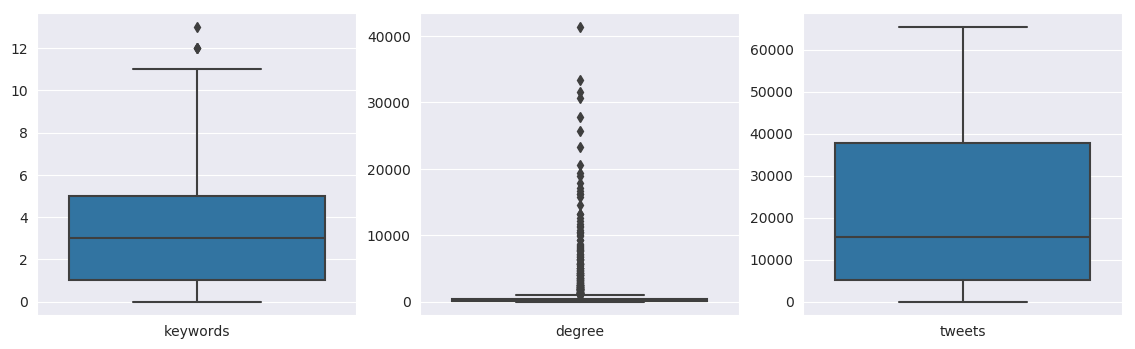

In [465]:
plt.figure(figsize=(14,4))
for i,column in enumerate(["keywords","degree","tweets"]):
    plt.subplot(1,3,i+1)
    sns.boxplot(data=really_unwanted_data_df[[column]])
plt.savefig(os.path.join(pictures_path,"boxplot_companies_final.png"))

In [467]:
really_unwanted_data_df.sort_values(by="keywords", ascending=False, inplace=True)

Hereby I show the top 20 entries sorted by the amount of description keywords:

In [471]:
really_unwanted_data_df.head(20)

,username,encoding,is_verified,tweets,keywords,degree
11369,audiukcare,17456347,False,19995,13,109
11434,avivauksupport,1597439,True,58523,12,364
22108,superdrughelp,59951357,False,49576,12,297
24195,zenithsupport,21316866,False,3515,12,12
13888,dstvngcare,73756998,False,346,11,628
13542,dfscare,74259097,False,26924,10,73
9615,asksageuki,51197632,False,6007,10,44
4507,askecggh,83046897,False,1219,10,12
15073,ghdhelp,14674840,False,11819,10,39
23291,veserviceteam,68137017,False,7289,10,14


I may now dump to file the final DataFrame, in order to import it again from another notebook:

In [473]:
really_unwanted_data_df.to_csv("../data/data_cleanup/final_excluded_usernames.csv", index=False)